In [1]:
# Imports 
%matplotlib inline
from pytriqs.lattice import BravaisLattice, BrillouinZone
from pytriqs.gf import Gf, MeshProduct, MeshBrillouinZone, MeshImFreq, Idx
from pytriqs.plot.mpl_interface import plt
import numpy as np
import warnings 
warnings.filterwarnings("ignore") #ignore some matplotlib warnings
from math import cos, pi
plt.rcParams["figure.figsize"] = (10,9) # set default size for all figures

## Lattice non-interacting Green function

In this notebook, we will consider a square lattice with nearest-neighbour hopping $t$.
The dispersion relation for this model is simply:

\begin{equation}
  \epsilon(\mathbf{k})=-2t(\cos{k_x}+\cos{k_y}),
\end{equation}

where $\mathbf{k}$ is a vector in the Brillouin zone (in units where the lattice spacing is unity $a=1$). The non-interacting Green's function for this lattice is given by

\begin{equation}
  G_0(\mathbf{k}, i\omega_n) = \frac{1}{i\omega_n - \epsilon(\mathbf{k})}
\end{equation}

### Exercise 1:

Following the notebook introducing multivariable Green functions, create an
object `g0` that contains the non-interacting Green function $G_0(\mathbf{k},i\omega_n)$
of this lattice. You can use the parameters given below.

In [2]:
# Regroup some parameters of the computation used later

beta = 1/0.4 # Inverse temperature
t = 1.0      # Hopping   
n_k = 128    # Number of points in the Brillouin Zone mesh (for each dimension)
n_w = 128    # Number of Matsubara frequencies
mu = 0       # Chemical potential

# Write your code here, it should eventually define a variable g0

BL = BravaisLattice([(1, 0, 0), (0, 1, 0)]) # Two unit vectors in R3
BZ = BrillouinZone(BL) 

kmesh = MeshBrillouinZone(BZ, n_k=n_k)
wmesh = MeshImFreq(beta=beta, S='Fermion', n_max=n_w)

g0 = Gf(mesh=MeshProduct(kmesh, wmesh), target_shape=[])

def eps(k):
    return -2 * t* (cos(k[0]) + cos(k[1]))

for k in g0.mesh[0]:
    for w in g0.mesh[1]:
        g0[k, w] = 1/(w - eps(k))

### Exercice 2:

Save the Green function `g0` into an archive `tpsc.h5`. This will be useful because
we will use `g0` later in other notebooks.

In [3]:
from pytriqs.archive import HDFArchive
with HDFArchive("tpsc.h5") as R:
    R['g0_kw'] = g0

## For nearest-neighbor model, the Fermi surface is nested

Your goal here is to display the Fermi surface and see that it has perfect
nesting.

### Exercice 3:

Make a color plot of $-\frac{1}{\pi} Im G_0(\mathbf{k}, i\omega_0)$ over the
Brillouin zone.
For simplicity, we will neglect the fact that the first Matsubara frequency
$i\omega_0$ is not exactly $0$ at finite temperature and approximate the spectral function
at $k$ and $\omega=0$ by this quantity.

Hint: Here is an example of a code that makes a color plot of the
function $k_x^2 + k_y^2$. You can use it as a model to write your code.

```python
func = lambda kx, ky: kx**2+ky**2

kgrid1d = np.linspace(-np.pi, np.pi, 100, endpoint=True)
kx, ky = np.meshgrid(kgrid1d, kgrid1d) 
plt.pcolor(kx, ky, np.vectorize(func)(kx,ky))
```

You should see from the plot that the Fermi surface is **nested**:

  * What do we mean by that?
  * What is the nesting vector?

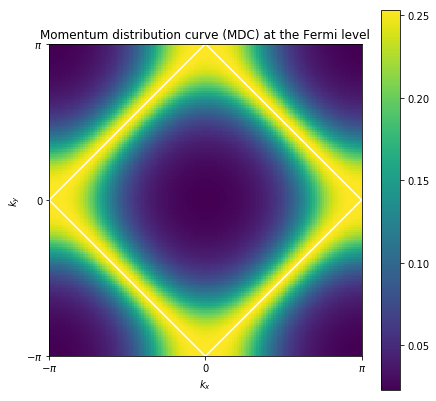

In [4]:
# take a simple numpy grid (independant of the actual grid of g0)
kgrid1d = np.linspace(-np.pi, np.pi, n_k + 1, endpoint=True)  # a linear grid
kx, ky = np.meshgrid(kgrid1d, kgrid1d)                        # a 2d grid of points from numpy 

# To make the matplotlib plot, we need a function kx, ky -> real
# so we quickly make two simple ones...

# The spectral function vs k at \omega_0
spectral = lambda kx, ky: -g0( (kx,ky,0), 0).imag / pi

# The denominator that should vanish at the location of the Fermi surface.
fs = lambda kx, ky: (1/g0( (kx,ky,0) , 0)).real

# make the color plot
plt.figure(figsize=(7,7))
plt.pcolor(kx, ky, np.vectorize(spectral)(kx,ky))
plt.colorbar()
plt.contour(kx, ky, np.vectorize(fs)(kx,ky), levels=[0], colors='white')
plt.axes().set_aspect('equal')

# Cosmetics
plt.xticks([-np.pi, 0, np.pi],[r"$-\pi$", r"0", r"$\pi$"])    
plt.yticks([-np.pi, 0, np.pi],[r"$-\pi$", r"0", r"$\pi$"])
plt.xlabel(r"$k_x$"); plt.ylabel(r"$k_y$")
plt.title("Momentum distribution curve (MDC) at the Fermi level");

### Exercice 4:

Plot the momentum distribution $n_\mathbf{k}$ along a diagonal of the Brillouin zone.

Hint 1: in order to obtain the density for a given value of $\mathbf{k}$ you
may want to:

  - Do a partial evaluation (see introduction to multivariable Green functions)
    of `g0` at the vector $\mathbf{k}$
  - Use the `density()` method studied in previous tutorials on this partially evaluated Green function
  
Hint 2: Here is a code that plots a function of $k$ along the diagonal of the Brillouin
zone:

```python
func = lambda k: k**2
kgrid1d = np.linspace(-np.pi, np.pi, 100, endpoint=True)
plt.plot(kgrid1d, np.vectorize(func)(kgrid1d))
```
  
Can you see a signature of the Fermi surface on this plot?

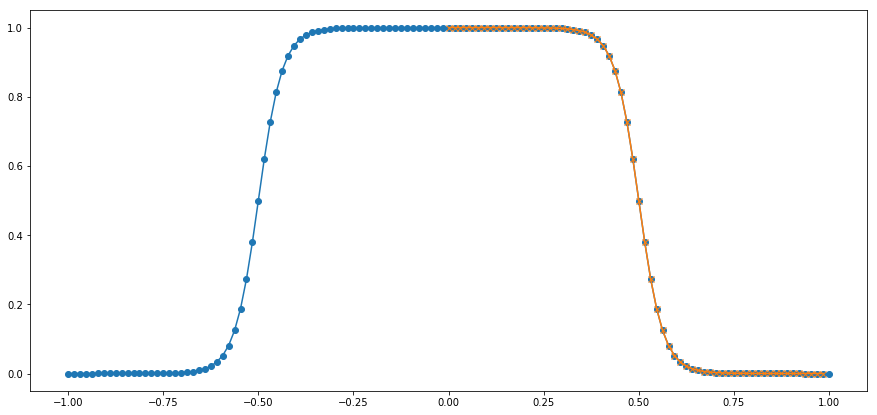

In [5]:
plt.figure(figsize=(15,7))

# function k-> g0(k, :) and take the density, a function seen in a previous tutorial (GfImFreq). 
# You are plotting the occupation probability in momentumm state k
n_of_k = lambda k: g0 ( (k, k,0),all).density().real
plt.plot(kgrid1d/pi, np.vectorize(n_of_k)(kgrid1d), '-o')

# Internal check of consistencty, not part of the question
# We replot using the point *on the grid* directly. 
# Idx(k_idx,k_idx,0) is the index of points on the grid 
if 1: 
    d = lambda k_idx: g0[Idx(k_idx,k_idx,0),:].density().real 
    kr = range(n_k/2)
    plt.plot([x /(n_k/2.0) for x in kr], np.vectorize(d)(kr), '-x')
